# Lab Assignment 5

**Computer Vision** - Term 5, 2022

Instructor: Dr. Saumya Jetly <br>
TA: Ribhu Lahiri

*Deadline: Wednesday, 30 March 2022 11:59 pm* 

Submission form link: https://forms.gle/8dDnoqnYHtAyUqSx7

Total points: 5 (with potential extra credit)


In this lab, you will be working with autoencoders. 

In [1]:
import math
import torch
import torch.nn.functional as F
import torchvision
from torchvision.datasets import MNIST
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

In [2]:
torch.manual_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## Part 1 – The Autoencoder (3 points)

In the first part, you will be creating a simple autoencoder with one hidden layer in each of the encoder and decoder. There are dimensions already specified but feel free to experiment.

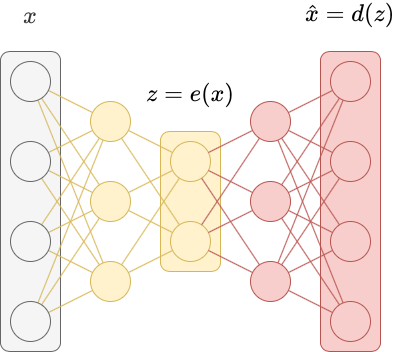

**Implement the `Encoder`** *(1 point)*

In [72]:
import torch
import torch.nn as nn

class Encoder(torch.nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        # linear layer 1: flatten, 512
        # linear layer 2: 512, latent_dim
        self.linear_layer1 = nn.Linear(784, 512)
        self.linear_layer2 = nn.Linear(512, latent_dims)

    def forward(self, x):
        # x = x.view(x.size(0), -1)
        x = x.view(256, 784)
        return self.linear_layer2(self.linear_layer1(x.squeeze(1)))

**Implement the `Decoder`** *(1 point)*

In [73]:
class Decoder(torch.nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        # linear layer 1: latent_dim, 512
        # linear layer 1: 512, flatten
        self.linear_layer1 = nn.Linear(latent_dims, 512)
        self.linear_layer2 = nn.Linear(512, 784)

    def forward(self, z):
        # remember to deflatten the output
        return self.linear_layer2(self.linear_layer1(z)).unsqueeze(1)

In [74]:
class Autoencoder(torch.nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

**Create the training loop using the `train` function** *(1 point)*

HINT: You can re-use parts from lab 4, such as the loss function but the weight updates will need to be done through an optimizer (`torch.optim`)

In [75]:
from torch.optim import Adam
torch.manual_seed(42)

In [76]:
def train(autoencoder, data, epochs=20):
    # Training Loop
    autoencoder = autoencoder.to(device)
    loss_fn = nn.BCELoss()
    optim = Adam(autoencoder.parameters(), lr = 1e-3)
    for epoch in range(epochs):
        epoch_loss = 0
        for train_batch in tqdm(data):
            optim.zero_grad()
            features, labels = train_batch
            features = features.float().to(device)
            labels = labels.float().to(device)
            preds = autoencoder(features)
            loss = loss_fn(preds, labels)
            loss.backward()
            optim.step()
            epoch_loss += loss.item()
        epoch_loss = epoch_loss / len(data)
        print(f"Epoch {epoch} completed.. Average Loss: {epoch_loss}")

    return autoencoder, epoch_loss

In [77]:
latent_dims = 2
autoencoder = Autoencoder(latent_dims).to(device)

data = torch.utils.data.DataLoader(
        MNIST('./data',
               transform=torchvision.transforms.ToTensor(),
               download=True),
        batch_size=256,
        shuffle=True)

autoencoder = train(autoencoder, data)

  0%|          | 0/235 [00:00<?, ?it/s]


ValueError: ignored

## Part 2 – The Variational Autoencoder (1 point)

In the second part, you will extend your encoder to be Variational so that it becomes a Variational Autoencoder. The distribution you need to map it to is a Normal distribution and use KL divergence as an Auxilliary Loss.

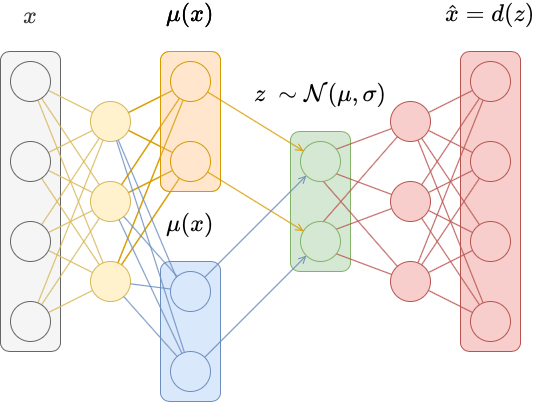

**Implement the `VariationalEncoder`** *(1 point)*

In [78]:
class VariationalEncoder(torch.nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        # linear layer 1: flatten, 512
        # linear layer 2: 512, latent_dim
        # linear layer 3: 512, latent_dim
        self.linear_layer1 = nn.Linear(784, 512)
        self.linear_layer2 = nn.Linear(512, latent_dims) #mu
        self.linear_layer3 = nn.Linear(512, latent_dims) #sigma

        self.N = torch.distributions.Normal(0, 1)
        self.kl = 0

        # Define normal distribution
        # Define Aux. Loss : KL divergence

    def forward(self, x):
        # Use both linear outputs to map to normal
        # Track Aux. loss here
        
        x = torch.flatten(x, start_dim=1)
        x = self.linear_layer1(x)
        mu =  self.linear_layer2(x)
        sigma = torch.exp(self.linear_layer3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z, self.kl

In [79]:
class VariationalAutoencoder(torch.nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

Re-use the training loop from above with minor adjustments (like including the aux. loss)

In [80]:
def train(autoencoder, data, epochs=20):
    # Training Loop
    autoencoder = autoencoder.to(device)
    loss_fn = nn.BCELoss()
    optim = Adam(autoencoder.parameters(), lr = 1e-3)
    for epoch in range(epochs):
        epoch_loss = 0
        for train_batch in tqdm(data):
            optim.zero_grad()
            features, labels = train_batch
            features = features.float().to(device)
            labels = labels.float().to(device)
            preds, kl = autoencoder(features)
            loss = loss_fn(preds, labels) + kl
            loss.backward()
            optim.step()
            epoch_loss += loss.item()
        epoch_loss = epoch_loss / len(data)
        print(f"Epoch {epoch} completed.. Average Loss: {epoch_loss}")

    return autoencoder, epoch_loss

In [81]:
vae = VariationalAutoencoder(latent_dims).to(device)
vae = train(vae, data)

  0%|          | 0/235 [00:00<?, ?it/s]


RuntimeError: ignored

**Extra Credit** (1 point)
Implement a function to plot how moving in the latent space affects the output. Sample uniformly from the latent space and plot the results for both the AE and the VAE, is there a difference?

In [ ]:
# YOUR CODE HERE

## Part 3 – Convolutional VAE
In the final part, you need to implelment a convolutional VAE wherein the initial layers of your encoder are replaced by convolutional layers. Remember to use even-shaped kernels.

**Implement the `ConvVariationalEncoder`** *(1 point)*

In [86]:
class ConvVariationalEncoder(torch.nn.Module):
    def __init__(self, latent_dims):
        super(ConvVariationalEncoder, self).__init__()
        # conv layer 1: input, 32
        # conv layer 2: 32, 64
        # conv layer 3: 64, 128
        # linear layer 1: conv_out_layer_dim, 512
        # linear layer 2: 512, latent_dim
        # linear layer 3: 512, latent_dim
        self.Conv1 = nn.Conv2d(1, 32, 3)
        self.Conv2 = nn.Conv2d(32, 64, 3)
        self.Conv3 = nn.Conv2d(64, 128, 3)
        self.linear_layer1 = nn.Linear(3*3*128, 512)
        self.linear_layer2 = nn.Linear(512, latent_dims)
        self.linear_layer3 = nn.Linear(512, latent_dims)

    def forward(self, x):
        x = F.relu(self.Conv1(x))
        x = F.relu(self.Conv2(x))
        # x = x.view(-1, 32*20*20)
        x = x.view(8192, 1152)
        x = self.linear_layer1(x)
        mu = self.linear_layer2(x)
        logVar = self.linear_layer3(x)
        std = torch.exp(logVar/2)
        epsilon = torch.randn_like(std)
        z = mu + std * epsilon
        return z, mu, logVar


In [87]:
class ConvVariationalAutoencoder(torch.nn.Module):
    def __init__(self, latent_dims):
        super(ConvVariationalAutoencoder, self).__init__()
        self.encoder = ConvVariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [88]:
def train(autoencoder, data, epochs=20):
    #Training Loop
    autoencoder = autoencoder.to(device)
    loss_fn = nn.BCELoss()
    optim = Adam(autoencoder.parameters(), lr = 1e-3)
    for epoch in range(epochs):
        epoch_loss = 0
        for train_batch in tqdm(data):
            optim.zero_grad()
            features, labels = train_batch
            features = features.float().to(device)
            labels = labels.float().to(device)
            preds = autoencoder(features)
            loss = loss_fn(preds, labels)
            loss.backward()
            optim.step()
            epoch_loss += loss.item()
        epoch_loss = epoch_loss / len(data)
        print(f"Epoch {epoch} completed.. Average Loss: {epoch_loss}")

    return autoencoder, epoch_loss

In [89]:
latent_dims = 2

data = torch.utils.data.DataLoader(
        MNIST('./data',
               transform=torchvision.transforms.ToTensor(),
               download=True),
        batch_size=256,
        shuffle=True)

cvae = ConvVariationalAutoencoder(latent_dims).to(device)
cvae = train(cvae, data)

  0%|          | 0/235 [00:00<?, ?it/s]


TypeError: ignored

In the following parts, try to visualise your kernels. Use the code as reference, and modify it as you like. What can you say about the filters? Would using deconvolutions change how they look?

### Layer 1 Visualisation

In [ ]:
fig = plt.figure(figsize=(4,7))
detached = cvae.state_dict()['encoder.conv1.weight'].cpu().detach().numpy()
for i,filt in enumerate(detached):
    ax1 = fig.add_subplot(4,7,i+1)
    ax1.imshow(filt,cmap='gray', vmin=0, vmax=255)
    ax1.axis('off')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])

### Layer 2 Visualisation

In [ ]:
fig = plt.figure(figsize=(4,7))
detached = cvae.state_dict()['encoder.conv2.weight'][0].cpu().detach().numpy()
for i,filt in enumerate(detached):
    ax1 = fig.add_subplot(4,7,i+1)
    ax1.imshow(filt)
    ax1.axis('off')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])